In [1]:
import os

# Setup Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'nguynminhkhu123'
os.environ['KAGGLE_KEY'] = 'KGAT_7d1d830678c09d78ca09c6cd897912f6'

DATA_DIR = "Data"
DATA_FILE = os.path.join(DATA_DIR, "Electric_Vehicle_Population_Data.csv")

if os.path.exists(DATA_FILE):
    print("📌 Dữ liệu đã tồn tại — bỏ qua bước tải!")
else:
    try:
        import kaggle
        print("⬇️  Đang tải dữ liệu từ Kaggle...")
        kaggle.api.dataset_download_files(
            'yanghu583/electric-vehicle-population-data-2025',
            path=DATA_DIR,
            unzip=True
        )
        print("✅ Tải thành công!")
        print("📁 Files trong Data:", os.listdir(DATA_DIR))
    except ImportError:
        print("⚠️ Kaggle library chưa cài. Chạy: !pip install kaggle")
    except Exception as e:
        print(f"❌ Lỗi: {e}")


📌 Dữ liệu đã tồn tại — bỏ qua bước tải!


#### Thêm thư viện

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
df = pd.read_csv('./Data/Electric_Vehicle_Population_Data.csv')
df_raw = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250659 entries, 0 to 250658
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         250659 non-null  object 
 1   County                                             250653 non-null  object 
 2   City                                               250653 non-null  object 
 3   State                                              250659 non-null  object 
 4   Postal Code                                        250653 non-null  float64
 5   Model Year                                         250659 non-null  int64  
 6   Make                                               250659 non-null  object 
 7   Model                                              250659 non-null  object 
 8   Electric Vehicle Type                              250659 non-null  object

In [5]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJSA1E65N,Yakima,Granger,WA,98932.0,2022,TESLA,MODEL S,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,187279214,POINT (-120.1871 46.33949),PACIFICORP,5.307700e+10
1,KNDC3DLC5N,Yakima,Yakima,WA,98902.0,2022,KIA,EV6,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0.0,0.0,15.0,210098241,POINT (-120.52041 46.59751),PACIFICORP,5.307700e+10
2,5YJYGDEEXL,Snohomish,Everett,WA,98208.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291.0,0.0,44.0,121781950,POINT (-122.18637 47.89251),PUGET SOUND ENERGY INC,5.306104e+10
3,3C3CFFGE1G,Yakima,Yakima,WA,98908.0,2016,FIAT,500,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,14.0,180778377,POINT (-120.60199 46.59817),PACIFICORP,5.307700e+10
4,KNDCC3LD5K,Kitsap,Bremerton,WA,98312.0,2019,KIA,NIRO,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,26.0,0.0,26.0,2581225,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10


### Loại bỏ một số cột ko cần thiết VIN,POSTAL CODE,BASE MSRP,LEGISLATICE DISTRICT,DOL VEHICLE ID,ELECTIRIC UTILITY,2020 CENSUS TRACT

In [6]:
df['DOL Vehicle ID'].nunique()

250659

### Làm đẹp dữ liệu (Cleaning)
Gồm các bước:
- Chuẩn hóa text  
- Chuẩn hóa loại xe (EV Type)  
- Chuẩn hóa hãng xe Make  
- Làm sạch năm Model  
- Xử lý missing  
- Loại bỏ duplicate  


In [7]:
print("=== START DATA CLEANING PIPELINE ===")
print(f"Initial rows: {len(df)}")
print("-----------------------------------")


cols_to_drop = [
    'Base MSRP',
    'DOL Vehicle ID',
    # 'VIN (1-10)',
    '2020 Census Tract'
]

existing_cols = [c for c in cols_to_drop if c in df.columns]

print(f"Dropping columns: {existing_cols}")
df.drop(columns=existing_cols, inplace=True, errors='ignore')
print(f"Columns removed. Remaining columns: {len(df.columns)}")
print("-----------------------------------")


# =====================================================
# 2. CHUẨN HÓA TEXT
# =====================================================
text_cols = [
    'Make', 'Model', 'Electric Vehicle Type',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'County', 'City'
]

print("Normalizing text columns...")
for col in text_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

print("Text normalization done.")
print("-----------------------------------")


# =====================================================
# EV TYPE FIX
# =====================================================
if 'Electric Vehicle Type' in df.columns:
    df['Electric Vehicle Type'] = df['Electric Vehicle Type'].replace({
        'Battery Electric Vehicle (Bev)': 'BEV',
        'Plug-In Hybrid Electric Vehicle (Phev)': 'PHEV',
    })
print("EV Type standardized.")
print("-----------------------------------")


# =====================================================
# Model Year Cleaning
# =====================================================
if 'Model Year' in df.columns:

    before = len(df)
    df['Model Year'] = pd.to_numeric(df['Model Year'], errors='coerce')

    # Remove invalid years
    df = df[df['Model Year'] >= 1995]

    df['Model Year'] = df['Model Year'].astype(int)

    after = len(df)
    print(f"Model Year cleaned. Removed: {before - after} rows")
print("-----------------------------------")


# =====================================================
# Make Standardization
# =====================================================
df['Make'] = df.get('Make', pd.Series()).replace({
    'Tesl': 'Tesla',
    'Tes': 'Tesla',
    'Chevy': 'Chevrolet'
})
print("Make column cleaned.")
print("-----------------------------------")


# =====================================================
# 3. XỬ LÝ MISSING
# =====================================================

# 3.1 Drop NA in City or County
if 'City' in df.columns and 'County' in df.columns:
    before = len(df)
    df = df.dropna(subset=['City', 'County'])
    after = len(df)
    print(f"Removed rows with missing City/County: {before - after}")
print("-----------------------------------")

# 3.2 Postal Code
if 'Postal Code' in df.columns:
    before = df['Postal Code'].isna().sum()

    df['Postal Code'] = df['Postal Code'].astype(str).str.strip()
    df['Postal Code'] = df['Postal Code'].replace({'': np.nan, '00000': np.nan})

    after = df['Postal Code'].isna().sum()
    print(f"Postal Code invalid entries: {after - before}")

    before_fill = df['Postal Code'].isna().sum()
    df['Postal Code'] = df['Postal Code'].ffill()
    after_fill = df['Postal Code'].isna().sum()

    print(f"Postal Code filled: {before_fill - after_fill}")
print("-----------------------------------")


# 4. ELECTRIC RANGE
if 'Electric Range' in df.columns:
    df['Electric Range'] = pd.to_numeric(df['Electric Range'], errors='coerce')

    # Không xóa dữ liệu — chỉ đổi 0 thành NaN
    zero_count = (df['Electric Range'] == 0).sum()
    df.loc[df['Electric Range'] == 0, 'Electric Range'] = np.nan

    print(f"Electric Range = 0 converted to NaN: {zero_count}")

# =====================================================
# 5. CLEAN CAFV
# =====================================================
caf_col = 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
if caf_col in df.columns:
    before = df[caf_col].isna().sum()
    df[caf_col] = df[caf_col].replace({'': np.nan})
    df[caf_col] = df[caf_col].fillna("Unknown")
    after = df[caf_col].isna().sum()

    print(f"CAFV missing filled: {before - after}")
print("-----------------------------------")


# =====================================================
# 6. CHUẨN HÓA CATEGORY
# =====================================================
category_cols = ['Make', 'Model', 'County', 'City', 'Electric Vehicle Type']
for c in category_cols:
    if c in df.columns:
        df[c] = df[c].astype('category')

print("Converted selected columns to category.")
print("-----------------------------------")


# =====================================================
# 7. DROP DUPLICATES (IGNORE ELECTRIC RANGE)
# =====================================================

# Lấy toàn bộ tên cột
all_columns = df.columns.tolist()

# Loại bỏ Electric Range khỏi danh sách check trùng
cols_for_duplicate = [c for c in all_columns if c != 'Electric Range']

before = len(df)
df = df.drop_duplicates(subset=cols_for_duplicate)
after = len(df)

print(f"Duplicate rows removed (ignoring Electric Range): {before - after}")
print("-----------------------------------")

# =====================================================
# SAVE CLEANED FILE
# =====================================================
output_path = "./Data/ev_cleaned.csv"
df.to_csv(output_path, index=False)

print(f"Saved cleaned data → {output_path}")
print("=== CLEANING COMPLETED ===")


=== START DATA CLEANING PIPELINE ===
Initial rows: 250659
-----------------------------------
Dropping columns: ['Base MSRP', 'DOL Vehicle ID', '2020 Census Tract']
Columns removed. Remaining columns: 14
-----------------------------------
Normalizing text columns...
Text normalization done.
-----------------------------------
EV Type standardized.
-----------------------------------
Model Year cleaned. Removed: 0 rows
-----------------------------------
Make column cleaned.
-----------------------------------
Removed rows with missing City/County: 0
-----------------------------------
Postal Code invalid entries: -6
Postal Code filled: 0
-----------------------------------
Electric Range = 0 converted to NaN: 152155
CAFV missing filled: 0
-----------------------------------
Converted selected columns to category.
-----------------------------------
Duplicate rows removed (ignoring Electric Range): 51898
-----------------------------------
Saved cleaned data → ./Data/ev_cleaned.csv
===

### so sánh dữ liệu


<Figure size 1600x600 with 0 Axes>

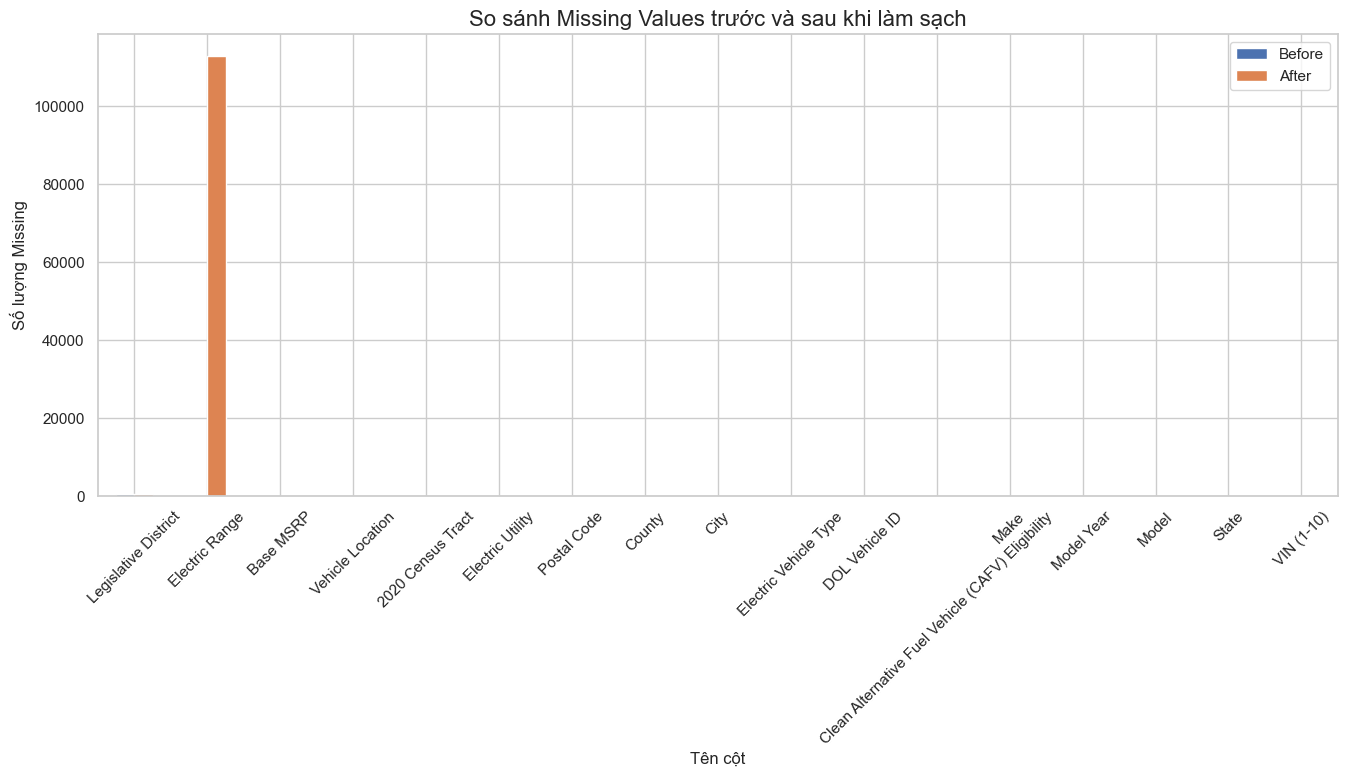

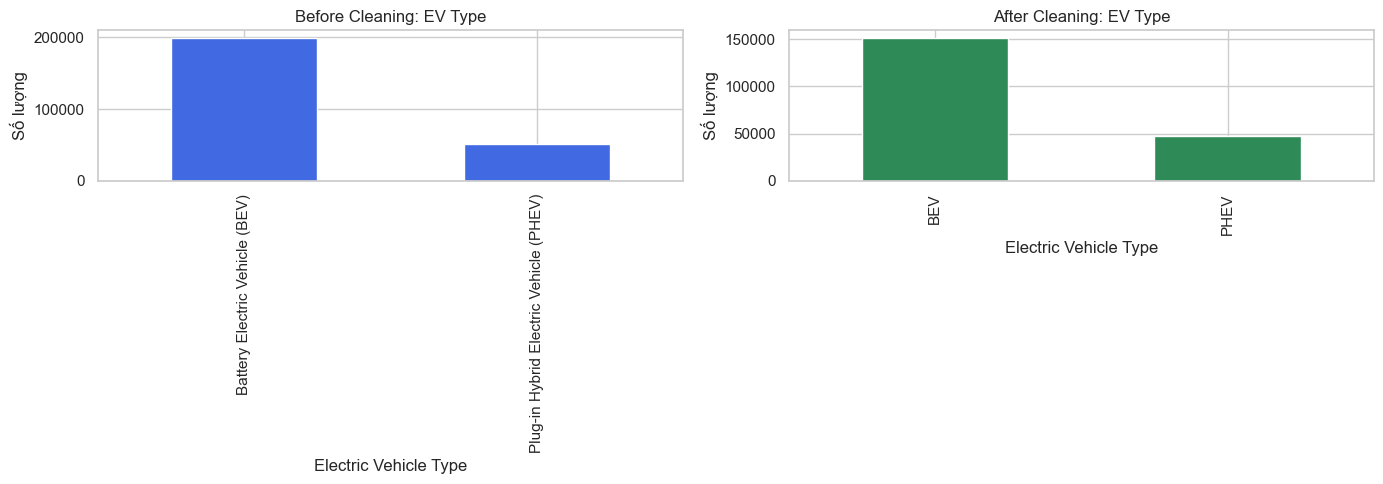

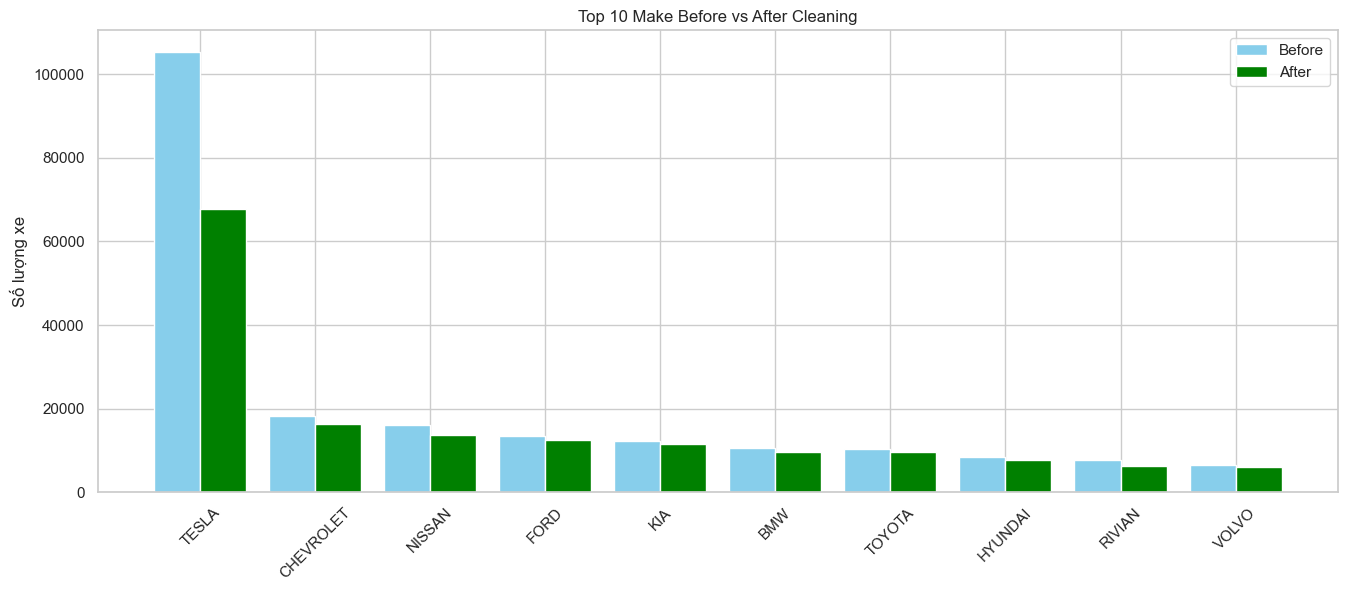

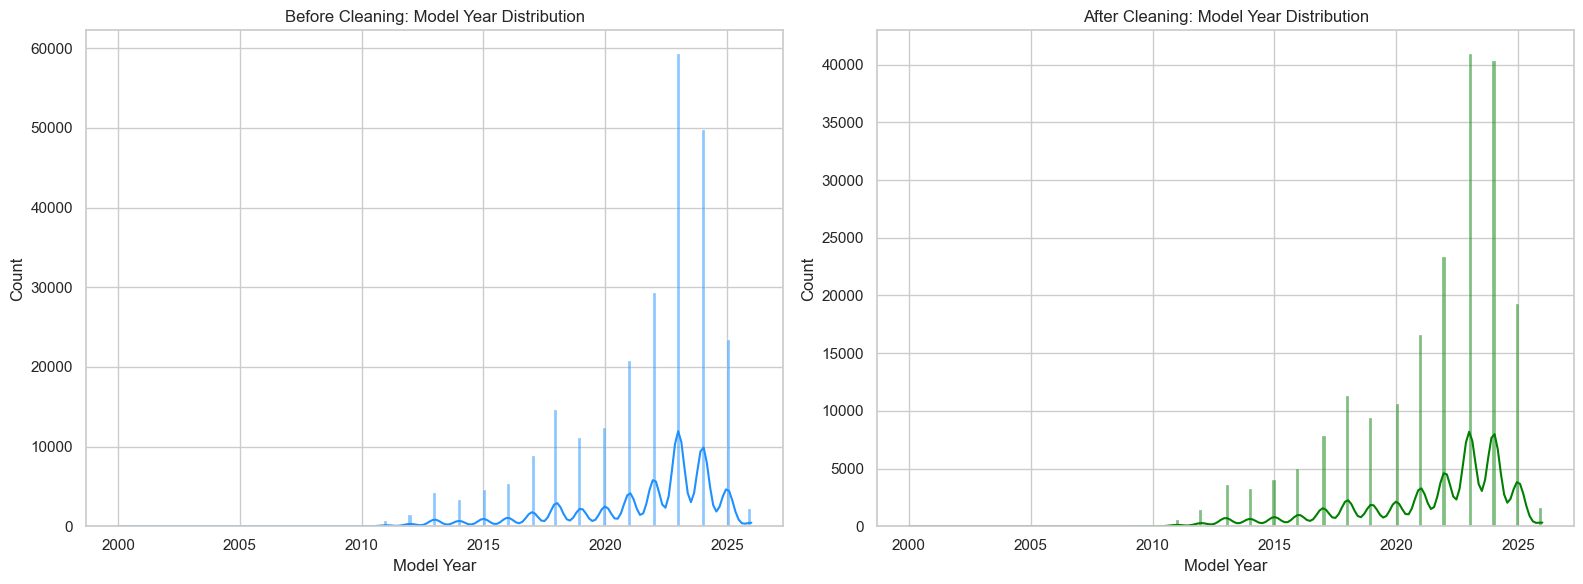

In [8]:
sns.set(style="whitegrid")

# ==========================
# 1. Missing Values Before vs After
# ==========================

na_before = df_raw.isna().sum()
na_after = df.isna().sum()

na_compare = pd.DataFrame({
    'Before': na_before,
    'After': na_after
}).sort_values("Before", ascending=False)

plt.figure(figsize=(16,6))
na_compare.plot(kind="bar", figsize=(16,6))
plt.title("So sánh Missing Values trước và sau khi làm sạch", fontsize=16)
plt.xlabel("Tên cột")
plt.ylabel("Số lượng Missing")
plt.xticks(rotation=45)
plt.show()



# ==========================
# 2. EV Type Before vs After
# ==========================

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
df_raw['Electric Vehicle Type'].value_counts().plot(kind='bar', color='royalblue')
plt.title("Before Cleaning: EV Type")
plt.ylabel("Số lượng")

plt.subplot(1,2,2)
df['Electric Vehicle Type'].value_counts().plot(kind='bar', color='seagreen')
plt.title("After Cleaning: EV Type")
plt.ylabel("Số lượng")

plt.tight_layout()
plt.show()



# ==========================
# 3. Top 10 Hãng Xe Before vs After
# ==========================

top_before = df_raw['Make'].value_counts().head(10)
top_after = df['Make'].value_counts().head(10)

plt.figure(figsize=(16,6))
x = np.arange(len(top_before.index))

plt.bar(x - 0.2, top_before.values, width=0.4, label="Before", color='skyblue')
plt.bar(x + 0.2, top_after.values, width=0.4, label="After", color='green')

plt.xticks(x, top_before.index, rotation=45)
plt.title("Top 10 Make Before vs After Cleaning")
plt.ylabel("Số lượng xe")
plt.legend()
plt.show()


# ==========================
# 4. Model Year Distribution Before vs After
# ==========================

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.histplot(df_raw['Model Year'], kde=True, color='dodgerblue')
plt.title("Before Cleaning: Model Year Distribution")

plt.subplot(1,2,2)
sns.histplot(df['Model Year'], kde=True, color='green')
plt.title("After Cleaning: Model Year Distribution")

plt.tight_layout()
plt.show()


In [9]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Legislative District,Vehicle Location,Electric Utility
0,5YJSA1E65N,Yakima,Granger,WA,98932.0,2022,Tesla,Model S,BEV,Eligibility Unknown As Battery Range Has Not B...,NaN,15.0,POINT (-120.1871 46.33949),PACIFICORP
1,KNDC3DLC5N,Yakima,Yakima,WA,98902.0,2022,Kia,Ev6,BEV,Eligibility Unknown As Battery Range Has Not B...,NaN,15.0,POINT (-120.52041 46.59751),PACIFICORP
2,5YJYGDEEXL,Snohomish,Everett,WA,98208.0,2020,Tesla,Model Y,BEV,Clean Alternative Fuel Vehicle Eligible,291.0,44.0,POINT (-122.18637 47.89251),PUGET SOUND ENERGY INC
3,3C3CFFGE1G,Yakima,Yakima,WA,98908.0,2016,Fiat,500,BEV,Clean Alternative Fuel Vehicle Eligible,84.0,14.0,POINT (-120.60199 46.59817),PACIFICORP
4,KNDCC3LD5K,Kitsap,Bremerton,WA,98312.0,2019,Kia,Niro,PHEV,Not Eligible Due To Low Battery Range,26.0,26.0,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC


In [10]:
df.shape

(198761, 14)

In [11]:
df.isna().sum()

VIN (1-10)                                                0
County                                                    0
City                                                      0
State                                                     0
Postal Code                                               0
Model Year                                                0
Make                                                      0
Model                                                     0
Electric Vehicle Type                                     0
Clean Alternative Fuel Vehicle (CAFV) Eligibility         0
Electric Range                                       112885
Legislative District                                    580
Vehicle Location                                         14
Electric Utility                                          6
dtype: int64

A very few data points are missing so we can remove them 

In [12]:
df = df.dropna()

In [13]:
county_counts = df.groupby('County')['City'].count().sort_values(ascending=False)

px.bar(
    x=county_counts.index[:10],
    y=county_counts.values[:10],
    labels={'x': 'County Name', 'y': 'Number of Cars'},
    color=county_counts.values[:10],
    title="Top 10 County có số lượng xe EV nhiều nhất"
).show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\3919264473.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  county_counts = df.groupby('County')['City'].count().sort_values(ascending=False)


C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\4024694452.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\4024694452.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



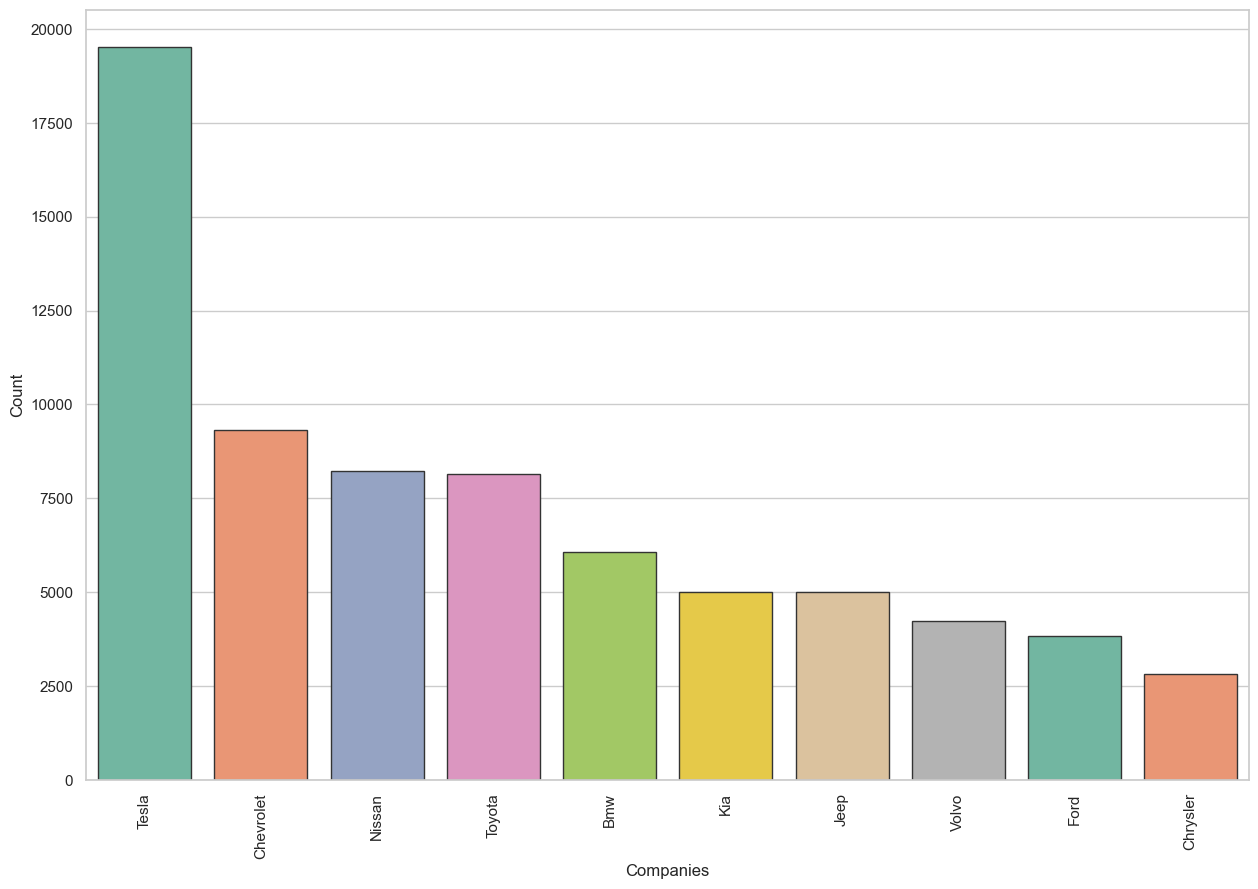

In [14]:
#lets see which company makes most of the electric vehicles
Companies = df.groupby('Make').count().sort_values(by='City',ascending=False)['City'].index
values = df.groupby('Make').count().sort_values(by='City',ascending=False)['City'].values


plt.figure(figsize=(15,10))
sns.barplot(x=list(Companies)[:10],
            y=values[:10],edgecolor='.2',palette='Set2',
            hue=list(Companies)[:10],  
            legend=False)              
plt.xticks(rotation=90)
plt.xlabel('Companies')
plt.ylabel('Count')
plt.show()

In [15]:
px.pie(names=list(Companies)[:10],values=values[:10],width=500,height=400)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\3668545669.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\3668545669.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\3668545669.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




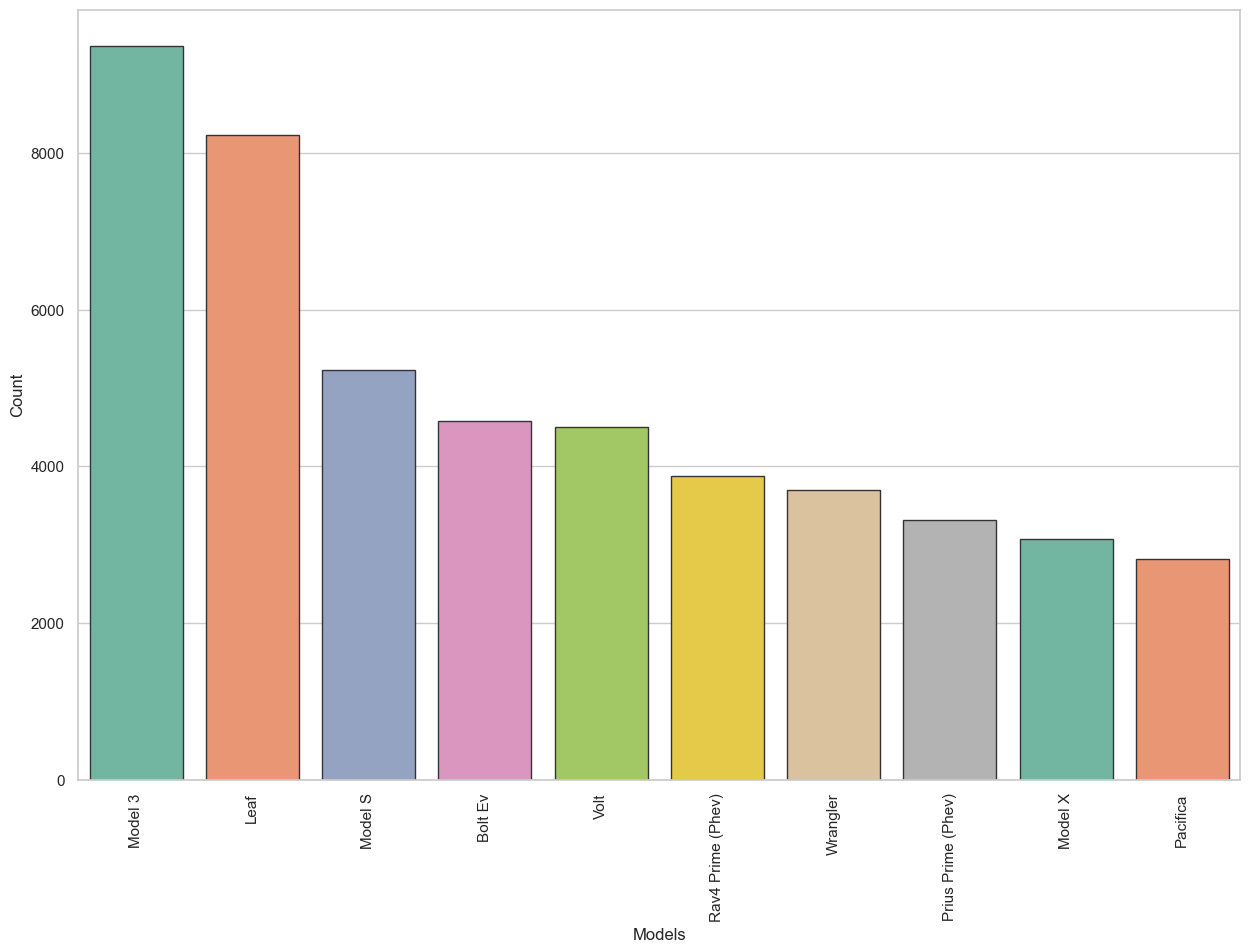

In [16]:
#Top 10 models in use

Models = df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].index
values = df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].values


plt.figure(figsize=(15,10))
sns.barplot(x=list(Models)[:10],y=values[:10],edgecolor='.2',palette='Set2')
plt.xticks(rotation=90)
plt.xlabel('Models')
plt.ylabel('Count')
plt.show()

In [17]:
#what are the most sold models per each company
#lets consider the top 10 companies
top_10_companies = list(Companies)[:10]
for i in top_10_companies:
    data = df[df['Make']==i]
    data = data.groupby('Model').count().sort_values(by='City',ascending=False).index
    print('Top selling model for',i,'is ----------->',data[0])

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The de

Top selling model for Tesla is -----------> Model 3
Top selling model for Chevrolet is -----------> Bolt Ev
Top selling model for Nissan is -----------> Leaf
Top selling model for Toyota is -----------> Rav4 Prime (Phev)
Top selling model for Bmw is -----------> X5
Top selling model for Kia is -----------> Niro
Top selling model for Jeep is -----------> Wrangler
Top selling model for Volvo is -----------> Xc90
Top selling model for Ford is -----------> Fusion
Top selling model for Chrysler is -----------> Pacifica


C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2491969221.py:6: FutureWarning:

The de

In [18]:
#Percentage of BEV vs PHEV

Vehicle_type = list(df.groupby('Electric Vehicle Type').count()['County'].index)
values = df.groupby('Electric Vehicle Type').count()['County'].values

px.pie(names=Vehicle_type,values=values,height=400)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2605965667.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2605965667.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [19]:
#lets see whats the percentage of top 10 companies vehicles are BEV and PHEV

for index,i in enumerate(top_10_companies):
    data = df[df['Make']==i]
    labels = list(data.groupby('Electric Vehicle Type').count()['City'].index)
    values = list(data.groupby('Electric Vehicle Type').count()['City'].values)
    fig = px.pie(names=labels,values=values,width=700,height=400,title=str(i))
    fig.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\1516018014.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='Electric Range', ylabel='Count'>

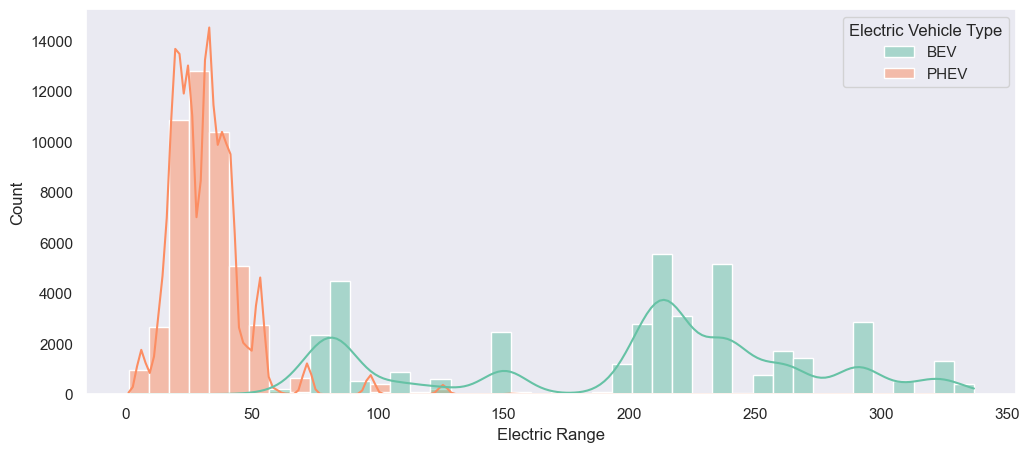

In [20]:
#lets see the electric range difference between PHEV and BEV
plt.figure(figsize=(12,5))
sns.set_style(style='dark')
sns.histplot(x = 'Electric Range',data=df,kde=True,hue='Electric Vehicle Type',palette='Set2')

In [21]:
#the data shows that BEVs will give more range but there are some vehicles which give almost 0 range on PHEV

In [22]:
df[df['Electric Range']==0].shape

(0, 14)

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2063471799.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



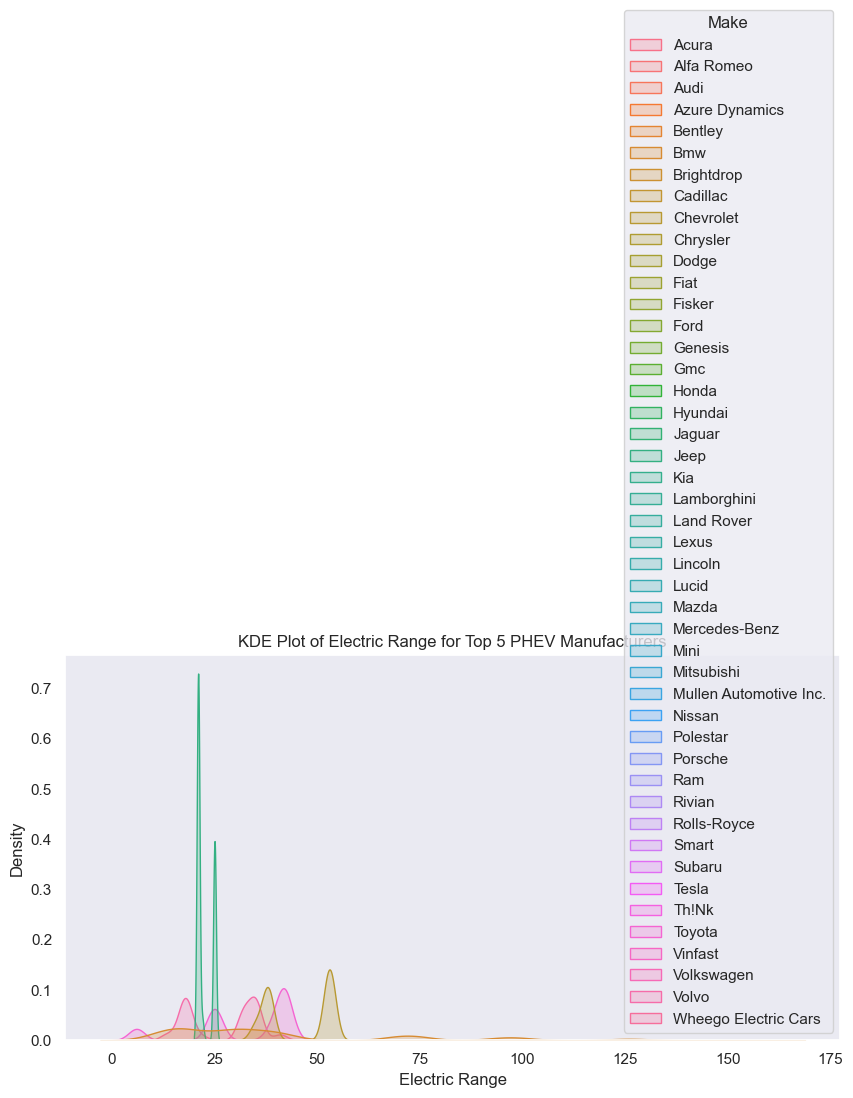

In [23]:
#Dùng data sau chuẩn hóa
data_phev = df[df['Electric Vehicle Type'] == 'PHEV']

# Loại bỏ NA trong Electric Range
data_phev = data_phev.dropna(subset=['Electric Range'])

# Lấy top 5 hãng PHEV
companies = (
    data_phev.groupby('Make')['City']
    .count()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filter theo top 5 hãng
data_phev = data_phev[data_phev['Make'].isin(companies)]

plt.figure(figsize=(10,5))
sns.kdeplot(
    data=data_phev,
    x='Electric Range',
    hue='Make',
    fill=True,
    common_norm=False
)
plt.title("KDE Plot of Electric Range for Top 5 PHEV Manufacturers")
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\2626622709.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='Electric Range', ylabel='Density'>

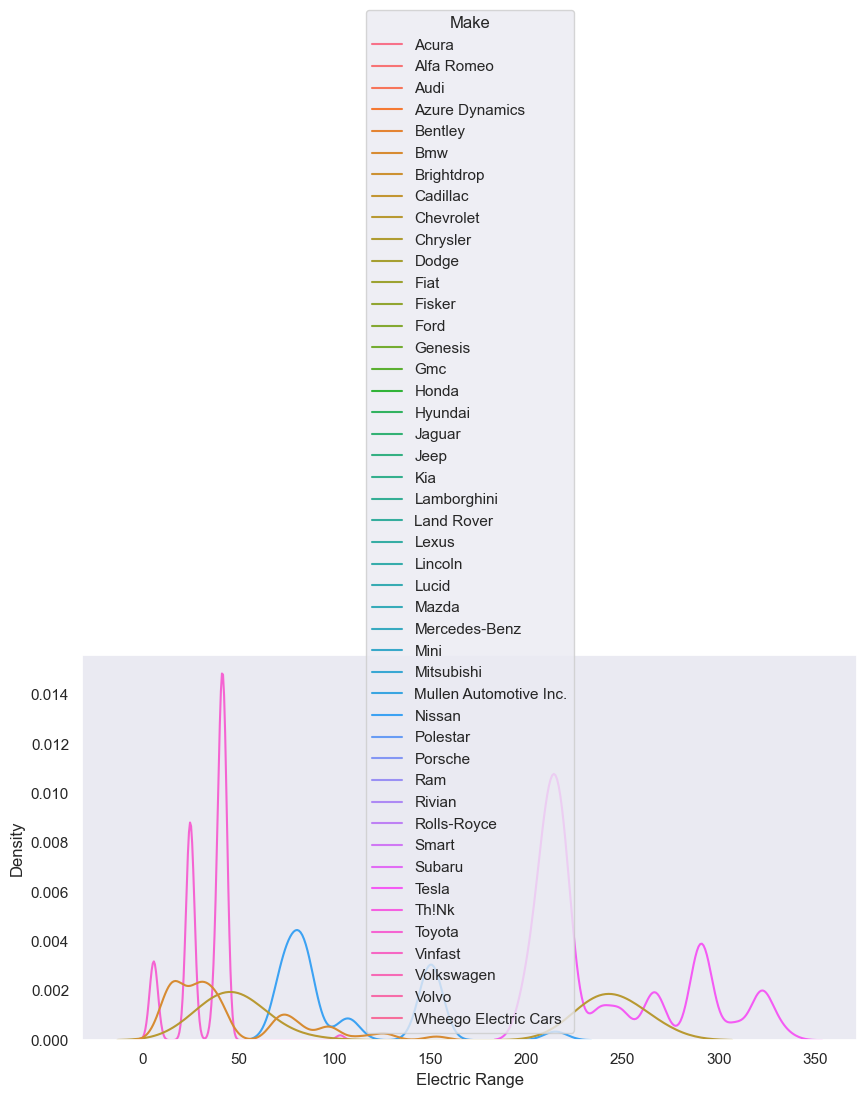

In [24]:
#BEV


data_bev = df[df['Electric Vehicle Type']!='Plug-in Hybrid Electric Vehicle (PHEV)']
companies=list(data_bev.groupby('Make').count().sort_values(by='City',ascending=False)['City'].index)[:5]
data_bev['bev'] = data_bev['Make'].apply(lambda x:1 if x in companies else 0 )
data_bev = data_bev[data_bev['bev']==1]

plt.figure(figsize=(10,5))
sns.kdeplot(x='Electric Range',hue='Make',data=data_bev)

In [25]:
top_10_vehicles = list(df.groupby('Model').count().sort_values(by='City',ascending=False)['City'].index)[:10]

C:\Users\Asus\AppData\Local\Temp\ipykernel_10700\4203574769.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [26]:
top_10_range =  df.sort_values(by='Electric Range',ascending=False)['Model'].unique()[:10]

In [27]:
top_10_vehicles

['Model 3',
 'Leaf',
 'Model S',
 'Bolt Ev',
 'Volt',
 'Rav4 Prime (Phev)',
 'Wrangler',
 'Prius Prime (Phev)',
 'Model X',
 'Pacifica']

In [28]:
top_10_range

['Model S', 'Model 3', 'Macan', 'Model X', 'Model Y', 'Bolt Ev', 'Kona', 'Roadster', 'Niro', 'I-Pace']
Categories (178, object): ['330E', '500', '500E', '530E', ..., 'Xc90', 'Xm', 'Zdx', 'Zevo']

<Axes: xlabel='Model Year', ylabel='count'>

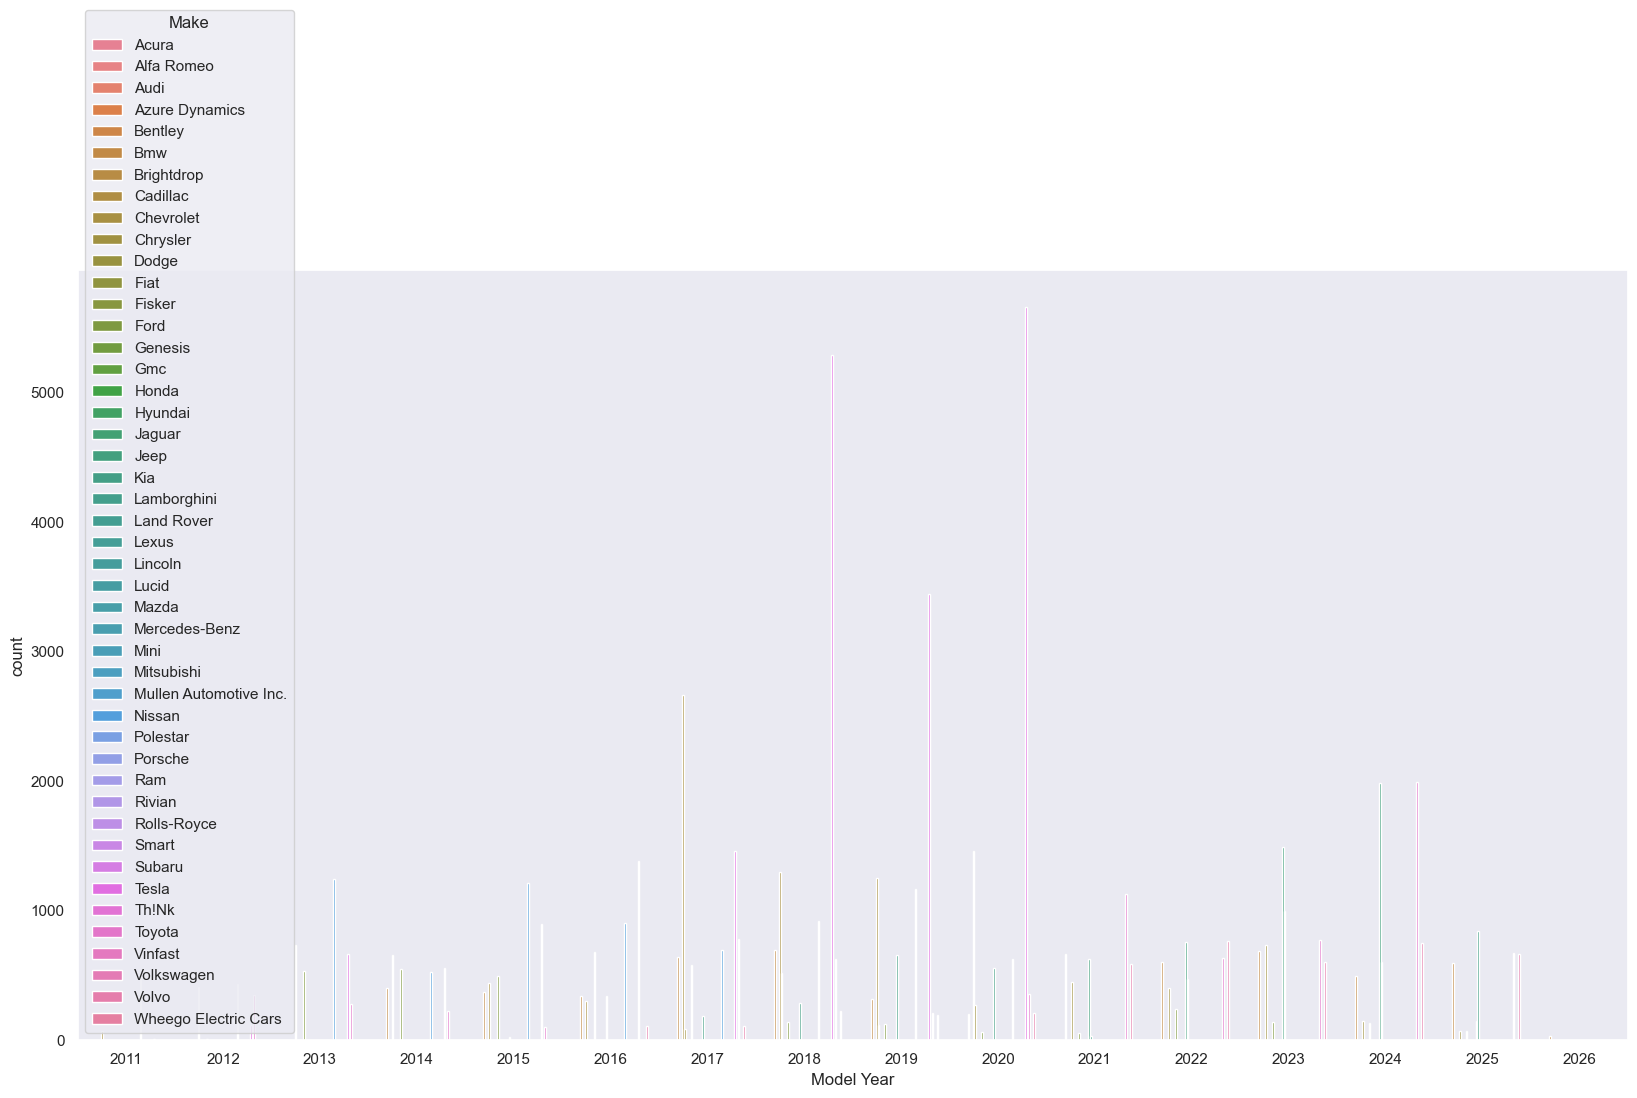

In [29]:
#Number of models of company for each year for last 10 years
#lets consider top_10 companies only

data = df.copy()
data['top_10'] = data['Make'].apply(lambda x:1 if x in top_10_companies else 0)
data = data[data['top_10']==1]
data = data[data['Model Year']>=2011]
plt.figure(figsize=(20,10))
sns.countplot(x = 'Model Year',hue='Make',data=data)

In [30]:
# 1.Bang nào đang có số lượng xe TESLA nhiều nhất?
# 2.Mẫu xe thuộc năm sản xuất nào của TESLA đang được sử dụng nhiều nhất?

data_TESLA = df[df['Make']=='Tesla']
top_10_states_TESLA = list(data_TESLA.groupby('State').count().sort_values(by='City',ascending=False)['City'].index)[:10]
values = list(data_TESLA.groupby('State').count().sort_values(by='City',ascending=False)['City'].values)[:10]

<Axes: >

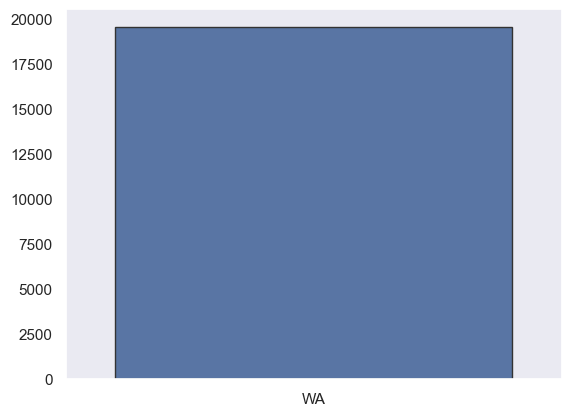

In [31]:
sns.barplot(x = top_10_states_TESLA,y=values,edgecolor='.2')

In [32]:
values

[np.int64(19534)]

In [33]:
#Most of the Tesla vehicles are from 'WA' state

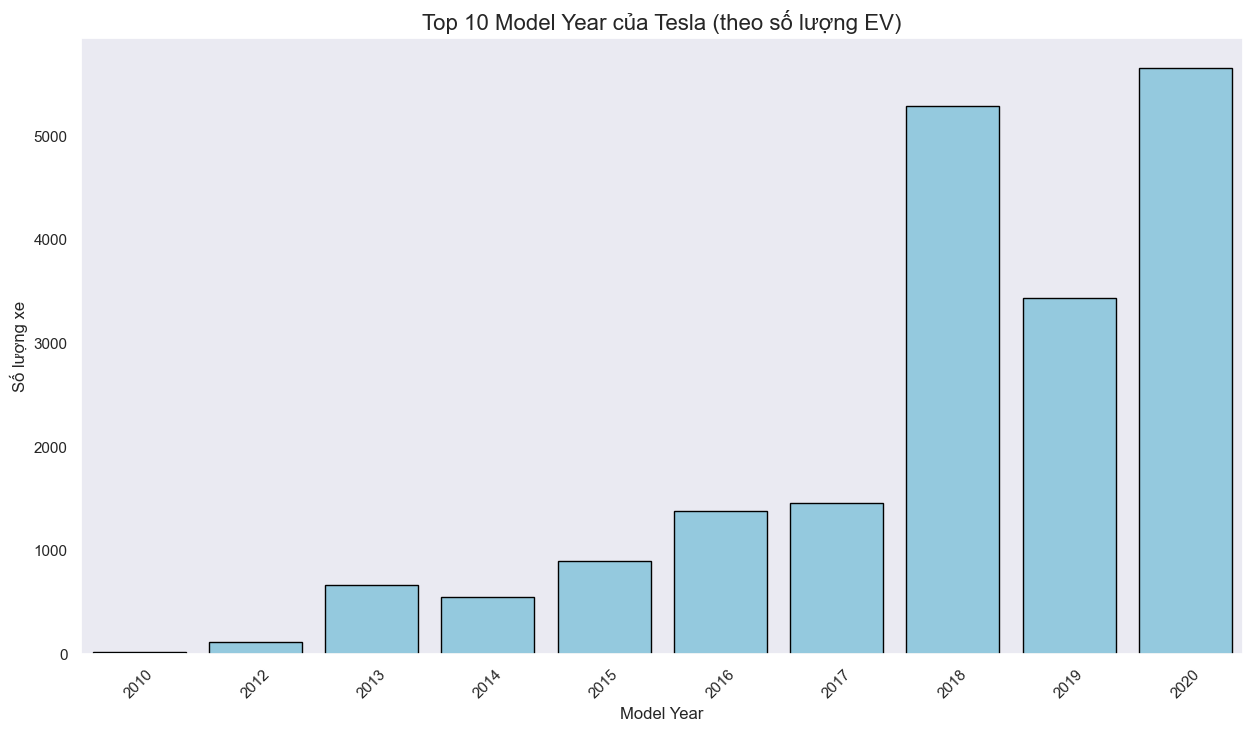

In [34]:
plt.figure(figsize=(15,8))

# Lọc Tesla
data_TESLA = df[df['Make'] == 'Tesla']

# Đếm số lượng theo Model Year
year_counts = data_TESLA['Model Year'].value_counts().sort_values(ascending=False)

# Lấy top 10
top_years = year_counts.head(10)

sns.barplot(x=top_years.index, y=top_years.values, edgecolor='black', color='skyblue')

plt.title("Top 10 Model Year của Tesla (theo số lượng EV)", fontsize=16)
plt.xlabel("Model Year")
plt.ylabel("Số lượng xe")
plt.xticks(rotation=45)
plt.show()


Phần lớn các mẫu xe do Tesla bán ra đều thuộc năm 2022.

(20.0, 60.0)

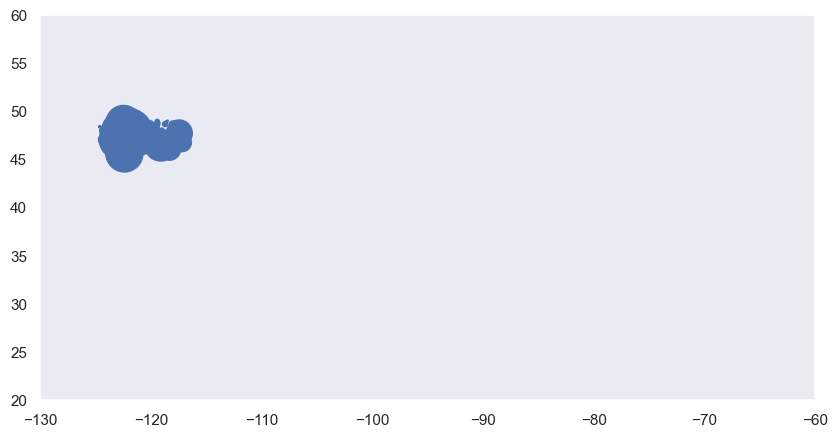

In [35]:
locations = list(df.groupby('Vehicle Location').count()['County'].index)
values = list(df.groupby('Vehicle Location').count()['County'].values)
Location_data = pd.DataFrame({'Locations':locations,'Count':values})
Location_data['Lattitude'] = Location_data['Locations'].apply(lambda x:float(x.split(' ')[1][1:]))
Location_data['Longitude'] = Location_data['Locations'].apply(lambda x:float(x.split(' ')[2][:-1]))

plt.figure(figsize=(10,5))
plt.scatter(x = Location_data['Lattitude'],y = Location_data['Longitude'],s=Location_data['Count'])
plt.xlim(-130,-60)
plt.ylim(20,60)


In [36]:
df['Lattitude'] = df['Vehicle Location'].apply(lambda x:float(x.split(' ')[1][1:]))
df['Longitude'] = df['Vehicle Location'].apply(lambda x:float(x.split(' ')[2][:-1]))

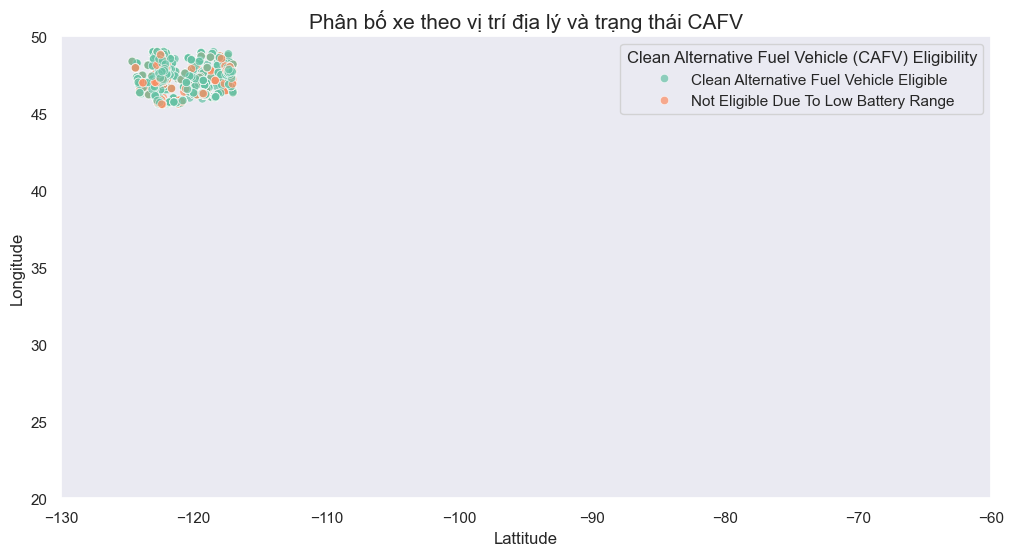

In [37]:
plt.figure(figsize=(12,6))

sns.scatterplot(
    x='Lattitude',
    y='Longitude',
    data=df,
    hue='Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    palette='Set2',
    alpha=0.7
)

plt.title("Phân bố xe theo vị trí địa lý và trạng thái CAFV", fontsize=15)
plt.xlim(-130, -60)
plt.ylim(20, 50)

plt.show()


(20.0, 50.0)

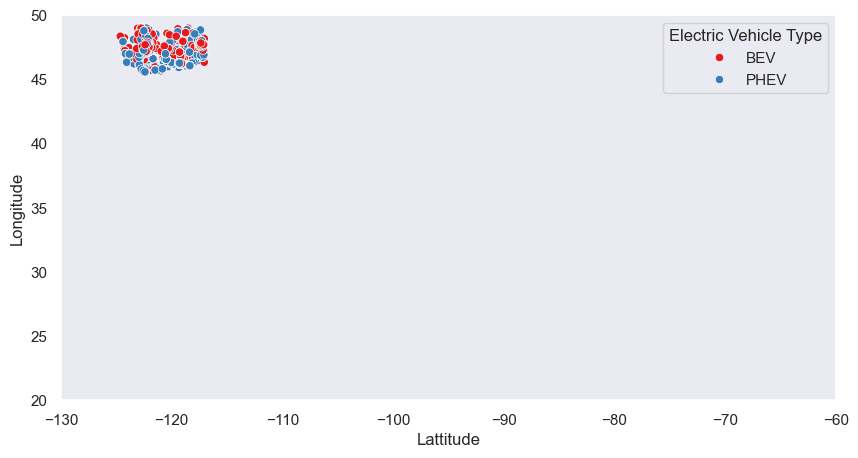

In [38]:
plt.figure(figsize=(10,5))
sns.scatterplot(x = 'Lattitude',y = 'Longitude',data=df,hue='Electric Vehicle Type',palette='Set1')
plt.xlim(-130,-60)
plt.ylim(20,50)

In [39]:
states = list(df.groupby('State').count().sort_values(by='City',ascending=False)['City'].index)
values = df.groupby('State').count().sort_values(by='City',ascending=False)['City'].values

In [40]:
data = pd.DataFrame(df.groupby('State').count().sort_values(by='City',ascending=False)['City'])

In [41]:
data = data.reset_index()

In [42]:
data.columns = ['State','Count']

In [43]:
fig = px.choropleth(data,
                    locations='State', 
                    locationmode="USA-states", 
                    color='Count',
                    color_continuous_scale="greens", 
                    scope="usa")

fig.show()

## Xu hướng phát triển xe điện tại bang Washington (2026–2030)

Chúng tôi xây dựng dự báo 5 năm (2026–2030) cho số lượng đăng ký xe theo hạt (county), hãng xe (make) và mẫu xe (model) bằng hai phương pháp chuỗi thời gian cùng cơ chế dự phòng:

- **ARIMA** – mô hình tự hồi quy – trung bình trượt tích hợp, phù hợp cho việc kéo dài xu hướng ngắn hạn.  
- **Theta** – phương pháp dự báo xu hướng ổn định, hoạt động hiệu quả trên các chuỗi dữ liệu ngắn.  
- Khi các mô hình thống kê gặp khó khăn do chuỗi dữ liệu quá thưa, chúng tôi sử dụng phương án dự phòng gồm xu hướng tuyến tính bảo thủ hoặc SES + drift.  
  Dự báo bắt đầu từ năm 2026 và các biểu đồ được trình bày với trục độc lập nhằm đảm bảo khả năng quan sát rõ ràng.

### Kết quả nổi bật từ bộ dự báo:

- **Theo từng hạt (County):**  
  Tăng trưởng mạnh nhất tiếp tục đến từ King County, với đà tăng ổn định tại Snohomish và Pierce.  
  Các hạt nông thôn tăng trưởng từ mức nền thấp hơn và thể hiện độ biến động lớn hơn.

- **Theo hãng xe (Make):**  
  Tesla duy trì vị thế dẫn đầu, trong khi Ford, Hyundai và Kia ghi nhận mức tăng ổn định khi danh mục xe điện của họ mở rộng.  
  Thị trường vẫn tập trung vào nhóm dẫn đầu nhưng có xu hướng đa dạng hóa theo thời gian.

- **Theo mẫu xe (Model):**  
  Top 10 mẫu xe (theo tổng số lượng sở hữu) tiếp tục giữ vị trí thống trị, đặc biệt là các dòng CUV cỡ nhỏ như Model Y, Mach-E, Ioniq 5/6 đang cho thấy đà tăng trưởng mạnh mẽ nhất.

In [44]:
import warnings
warnings.filterwarnings('ignore')

from typing import List

# Thử import các mô hình dự báo (ARIMA, Theta, SES);
# nếu không cài đặt thì gán None để fallback tự xử lý.
try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    ARIMA = None

try:
    from statsmodels.tsa.forecasting.theta import ThetaModel
except Exception:
    ThetaModel = None

try:
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing
except Exception:
    SimpleExpSmoothing = None

# Kiểm tra các cột bắt buộc phải có cho dự báo
required_cols = {'County', 'Make', 'Model', 'Model Year'}
missing_cols = required_cols - set(df.columns)
if missing_cols:
    raise ValueError(f"Các cột thiếu cho dự báo: {missing_cols}")

# Chuẩn hóa năm sản xuất thành số nguyên và loại bỏ giá trị không hợp lệ
df['Model Year'] = df['Model Year'].astype(int)

# Hàm tính tổng xe theo từng năm cho một nhóm (county / make / model)
def compute_yearly_counts(group_col: str) -> pd.DataFrame:
    counts = (
        df.groupby([group_col, 'Model Year'])
          .size()
          .reset_index(name='Count')
    )
    return counts

# Chọn ra top N nhóm có dữ liệu nhiều nhất (tính theo tổng hoặc theo năm mới nhất)
def select_top_groups(forecast_df: pd.DataFrame, group_col: str, top_n: int = 12, mode: str = 'latest') -> list:
    actuals = forecast_df[forecast_df['Type'] == 'Actual']
    if actuals.empty:
        return []
    if mode == 'total':
        totals = actuals.groupby(group_col)['Count'].sum().sort_values(ascending=False)
    else:
        latest_year = actuals['Year'].max()
        totals = (actuals[actuals['Year'] == latest_year]
                  .groupby(group_col)['Count'].sum()
                  .sort_values(ascending=False))
    return list(totals.head(top_n).index)

# Xây dựng chuỗi liên tục theo năm (fill missing = 0)
def build_continuous_series(sub: pd.DataFrame, year_col: str = 'Model Year', value_col: str = 'Count') -> pd.Series:
    years = np.arange(sub[year_col].min(), sub[year_col].max() + 1)
    series = sub.set_index(year_col)[value_col].reindex(years, fill_value=0)
    series.index.name = 'Year'
    return series.astype(float)

# Dự báo ARIMA cho từng nhóm, có fallback nếu mô hình không hội tụ
def forecast_arima_per_group(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series(sub_sorted)
        last_year = int(series.index.max())

        # Ghi nhận dữ liệu thực tế (Actuals)
        for year, cnt in series.items():
            records.append({group_col: group_value, 'Year': int(year), 'Count': float(cnt), 'Type': 'Actual'})

        # Thử chạy ARIMA
        preds = None
        if ARIMA is not None and len(series) >= 3:
            try:
                order = (0, 1, 1) if len(series) >= 4 else (1, 0, 0)
                model = ARIMA(series, order=order, enforce_stationarity=False, enforce_invertibility=False)
                fit = model.fit(method_kwargs={"warn_convergence": False})
                preds = fit.forecast(steps=horizon)
            except Exception:
                preds = None

        # Fallback tuyến tính nếu ARIMA lỗi
        if preds is None:
            x = series.index.values
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds = pd.Series([max(0.0, a * (last_year + k) + b)
                               for k in range(1, horizon + 1)],
                              index=[last_year + k for k in range(1, horizon + 1)])

        # Lưu dự báo
        for year, cnt in preds.items():
            records.append({group_col: group_value, 'Year': int(year),
                            'Count': float(max(0.0, cnt)), 'Type': 'ARIMA'})

    return pd.DataFrame.from_records(records)

# Dự báo Theta cho từng nhóm, có fallback SES hoặc tuyến tính
def forecast_theta_per_group(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series(sub_sorted)
        last_year = int(series.index.max())

        preds = None
        # Thử chạy Theta
        if ThetaModel is not None and len(series) >= 3:
            try:
                tm = ThetaModel(series)
                res = tm.fit()
                preds = res.forecast(horizon)
            except Exception:
                preds = None

        # Fallback SES + drift nếu Theta lỗi
        if preds is None:
            if SimpleExpSmoothing is not None and len(series) >= 2:
                try:
                    ses_fit = SimpleExpSmoothing(series).fit(optimized=True)
                    ses_fc = ses_fit.forecast(horizon)
                    t = np.arange(len(series))
                    slope, intercept = np.polyfit(t, series.values, 1)
                    drift = slope
                    preds = ses_fc + drift * np.arange(1, horizon + 1)
                except Exception:
                    preds = None

        # Fallback tuyến tính cuối cùng
        if preds is None:
            x = series.index.values
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds = pd.Series([max(0.0, a * (last_year + k) + b)
                               for k in range(1, horizon + 1)],
                              index=[last_year + k for k in range(1, horizon + 1)])

        # Lưu dự báo
        for year, cnt in preds.items():
            records.append({group_col: group_value, 'Year': int(year),
                            'Count': float(max(0.0, cnt)), 'Type': 'Theta'})

    # Thêm dữ liệu thực tế
    actuals = []
    for group_value, sub in counts.groupby(group_col):
        series = build_continuous_series(sub)
        for year, cnt in series.items():
            actuals.append({group_col: group_value, 'Year': int(year), 'Count': float(cnt), 'Type': 'Actual'})

    df_actuals = pd.DataFrame(actuals)
    return pd.DataFrame.from_records(records).append(df_actuals, ignore_index=True)

# Kết hợp dự báo ARIMA + Theta + dữ liệu thực tế
def combine_forecasts_arima_theta(counts: pd.DataFrame, group_col: str, horizon: int = 3) -> pd.DataFrame:
    arima_df = forecast_arima_per_group(counts, group_col, horizon)
    theta_df = forecast_theta_per_group(counts, group_col, horizon)
    combined = pd.concat([arima_df, theta_df], ignore_index=True)
    combined = combined.drop_duplicates(subset=[group_col, 'Year', 'Type'])
    return combined

# Xây dựng chuỗi dữ liệu liên tục từ năm đầu đến 2025 dưới dạng PeriodIndex để Statsmodels hiểu tần suất
def build_continuous_series_fixed_start(sub: pd.DataFrame, year_col: str = 'Model Year', value_col: str = 'Count') -> pd.Series:
    if sub.empty:
        return pd.Series(dtype=float)
    min_year = int(sub[year_col].min())
    max_hist_year = int(min(sub[year_col].max(), FORECAST_START_YEAR - 1))
    years = np.arange(min_year, max_hist_year + 1)
    series = sub.set_index(year_col)[value_col].reindex(years, fill_value=0).astype(float)
    series.index = pd.PeriodIndex(series.index.astype(int), freq='Y')
    series.index.name = 'Year'
    return series

# Dự báo đầy đủ ARIMA + Theta cho từng nhóm, đảm bảo bắt đầu từ 2026
def forecast_arima_theta_fixed_start(counts: pd.DataFrame, group_col: str) -> pd.DataFrame:
    records: List[dict] = []
    for group_value, sub in counts.groupby(group_col):
        if sub['Model Year'].nunique() < 2:
            continue
        sub_sorted = sub.sort_values('Model Year')
        series = build_continuous_series_fixed_start(sub_sorted)
        if series.empty:
            continue

        # Lưu dữ liệu thực tế (đến 2025)
        for pyear, cnt in series.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({group_col: group_value, 'Year': year_int,
                            'Count': float(cnt), 'Type': 'Actual'})

        steps = FORECAST_HORIZON

        # ARIMA có fallback
        preds_arima = None
        if ARIMA is not None and len(series) >= 3:
            try:
                order = (0, 1, 1) if len(series) >= 4 else (1, 0, 0)
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    model = ARIMA(series, order=order, enforce_stationarity=False, enforce_invertibility=False)
                    fit = model.fit(method_kwargs={"warn_convergence": False})
                converged = True
                try:
                    converged = bool(getattr(fit, 'mle_retvals', {}).get('converged', True))
                except Exception:
                    pass
                if converged:
                    preds_arima = fit.forecast(steps=steps)
            except Exception:
                preds_arima = None

        # Fallback ARIMA → tuyến tính nếu ARIMA lỗi
        if preds_arima is None:
            x = np.array([int(ix.year) for ix in series.index])
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds_arima = pd.Series(
                [max(0.0, a * (FORECAST_START_YEAR + k) + b)
                 for k in range(0, FORECAST_HORIZON)],
                index=pd.PeriodIndex(
                    [FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)],
                    freq='Y'
                )
            )

        # Theta có fallback SES hoặc tuyến tính
        preds_theta = None
        if ThetaModel is not None and len(series) >= 3:
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    tm = ThetaModel(series)
                    res = tm.fit()
                    preds_theta = res.forecast(steps)
            except Exception:
                preds_theta = None

        if preds_theta is None:
            if SimpleExpSmoothing is not None and len(series) >= 2:
                try:
                    ses_fit = SimpleExpSmoothing(series).fit(optimized=True)
                    ses_fc = ses_fit.forecast(FORECAST_HORIZON)
                    t = np.arange(len(series))
                    slope, intercept = np.polyfit(t, series.values, 1)
                    drift = slope
                    preds_theta = ses_fc + drift * np.arange(1, FORECAST_HORIZON + 1)
                    preds_theta.index = pd.PeriodIndex(
                        [FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)],
                        freq='Y'
                    )
                except Exception:
                    preds_theta = None

        if preds_theta is None:
            x = np.array([int(ix.year) for ix in series.index])
            y = series.values
            a, b = np.polyfit(x, y, 1)
            preds_theta = pd.Series(
                [max(0.0, a * (FORECAST_START_YEAR + k) + b)
                 for k in range(0, FORECAST_HORIZON)],
                index=pd.PeriodIndex(
                    [FORECAST_START_YEAR + k for k in range(0, FORECAST_HORIZON)],
                    freq='Y'
                )
            )

        # Căn chỉnh chỉ số dự báo về đúng các năm 2026–2028 (hoặc 2026–2030)
        target_idx = pd.PeriodIndex(
            [FORECAST_START_YEAR + i for i in range(0, FORECAST_HORIZON)],
            freq='Y'
        )
        try:
            preds_arima = preds_arima.reindex(target_idx)
        except Exception:
            preds_arima.index = target_idx

        try:
            preds_theta = preds_theta.reindex(target_idx)
        except Exception:
            preds_theta.index = target_idx

        # Lưu kết quả dự báo
        for pyear, cnt in preds_arima.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({
                group_col: group_value,
                'Year': year_int,
                'Count': float(max(0.0, cnt)),
                'Type': 'ARIMA'
            })
        for pyear, cnt in preds_theta.items():
            year_int = int(getattr(pyear, 'year', int(str(pyear))))
            records.append({
                group_col: group_value,
                'Year': year_int,
                'Count': float(max(0.0, cnt)),
                'Type': 'Theta'
            })

    return pd.DataFrame.from_records(records)

In [45]:
# Mở rộng dự báo thành 5 năm (2026–2030) và vẽ lại biểu đồ
FORECAST_START_YEAR = 2026
FORECAST_HORIZON = 5
FORECAST_END_YEAR = FORECAST_START_YEAR + FORECAST_HORIZON - 1

# Định nghĩa lại các hàm vẽ biểu đồ để tự động dùng horizon động trong tiêu đề
import plotly.express as px

def plot_actual_vs_forecast_local(
    forecast_df: pd.DataFrame,
    group_col: str,
    top_n: int = 12,
    title_prefix: str = "",
    top_select_mode: str = 'latest'  # 'latest' = dựa trên năm mới nhất, 'total' = tổng toàn chuỗi
):
    # Lấy dữ liệu thực tế
    actuals = forecast_df[forecast_df['Type'] == 'Actual']
    if actuals.empty:
        return
    
    # Chọn nhóm đứng đầu theo mode (latest hoặc total)
    if top_select_mode == 'total':
        totals = actuals.groupby(group_col)['Count'].sum().sort_values(ascending=False)
    else:
        latest_actual_year = actuals['Year'].max()
        totals = (actuals[actuals['Year'] == latest_actual_year]
                  .groupby(group_col)['Count']
                  .sum()
                  .sort_values(ascending=False))

    top_groups = list(totals.head(top_n).index)

    # Lọc dữ liệu chỉ gồm top nhóm
    dsub = forecast_df[forecast_df[group_col].isin(top_groups)].copy()
    dsub['Line'] = dsub['Type']           # kiểu dữ liệu (Actual, ARIMA, Theta)
    dsub['Group'] = dsub[group_col]       # tên nhóm để facet

    # Tạo tiêu đề
    title = (f"{title_prefix} Thực tế vs Dự báo {FORECAST_START_YEAR}–{FORECAST_END_YEAR} "
             f"(ARIMA & Theta) theo {group_col}")

    # Vẽ biểu đồ đường dạng facet
    fig = px.line(
        dsub,
        x='Year', y='Count',
        color='Line',
        facet_col='Group',
        facet_col_wrap=4,
        markers=True,
        title=title
    )
    fig.update_layout(width=1600, height=800)
    fig.show()


def plot_individual_group_forecasts(forecast_df: pd.DataFrame, group_col: str, groups: list, title_prefix: str = ""):
    # Vẽ dự báo cho từng nhóm 1 biểu đồ riêng
    for grp in groups:
        d = forecast_df[forecast_df[group_col] == grp].copy()
        if d.empty:
            continue
        d['Line'] = d['Type']

        # Lấy range năm thực tế
        actual_years = d.loc[d['Type'] == 'Actual', 'Year']
        x_min = int(actual_years.min()) if not actual_years.empty else int(d['Year'].min())
        x_max = FORECAST_END_YEAR

        # Range trục Y
        y_max = float(d['Count'].max()) if not d['Count'].empty else 0.0
        y_range = [0, max(1.0, y_max * 1.1)]

        # Tiêu đề biểu đồ
        title = (f"{title_prefix} {grp} — Thực tế vs Dự báo {FORECAST_START_YEAR}–{FORECAST_END_YEAR} "
                 f"(ARIMA & Theta)")

        # Vẽ biểu đồ
        fig = px.line(
            d,
            x='Year', y='Count',
            color='Line',
            markers=True,
            title=title
        )
        fig.update_layout(width=1000, height=450)
        fig.update_xaxes(range=[x_min, x_max])
        fig.update_yaxes(range=y_range)
        fig.show()

# Tính lại số lượng theo từng năm (County, Make, Model)
counts_county = compute_yearly_counts('County')
counts_make = compute_yearly_counts('Make')
counts_model = compute_yearly_counts('Model')

# Tạo dự báo ARIMA + Theta với horizon 2026–2030
fc_county_2630 = forecast_arima_theta_fixed_start(counts_county, 'County')
fc_make_2630 = forecast_arima_theta_fixed_start(counts_make, 'Make')
fc_model_2630 = forecast_arima_theta_fixed_start(counts_model, 'Model')

# Biểu đồ dạng facet
plot_actual_vs_forecast_local(fc_county_2630, 'County', top_n=12, title_prefix='County:')
plot_actual_vs_forecast_local(fc_make_2630, 'Make', top_n=12, title_prefix='Hãng xe:')
plot_actual_vs_forecast_local(fc_model_2630, 'Model', top_n=10, title_prefix='Model:', top_select_mode='total')

# Lấy top groups để vẽ biểu đồ riêng lẻ
top_counties = select_top_groups(fc_county_2630, 'County', top_n=12, mode='latest')
top_makes = select_top_groups(fc_make_2630, 'Make', top_n=12, mode='latest')
top_models = select_top_groups(fc_model_2630, 'Model', top_n=10, mode='total')

# Biểu đồ riêng cho từng nhóm
plot_individual_group_forecasts(fc_county_2630, 'County', top_counties, title_prefix='County:')
plot_individual_group_forecasts(fc_make_2630, 'Make', top_makes, title_prefix='Hãng xe:')
plot_individual_group_forecasts(fc_model_2630, 'Model', top_models, title_prefix='Model:')

# 📊 Kết luận từ các biểu đồ và mô hình dự báo

## 1. Nhận xét theo từng quận/hạt (County-level insights)

- **King County chiếm ưu thế**: Tăng trưởng mạnh theo dạng hàm mũ, phù hợp với vị thế của khu vực Seattle – nơi có mức độ chấp nhận xe điện sớm nhất.
- **Thị trường thứ cấp tăng trưởng đều**: Snohomish và Pierce cho thấy tốc độ tăng trưởng ổn định, phản ánh sự lan rộng của EV sang các khu vực ngoại ô.
- **Khu vực nông thôn còn chậm**: Các hạt nhỏ có mức tăng thất thường và chậm hơn do hạn chế về cơ sở hạ tầng và điều kiện kinh tế.
- **Khoảng cách tăng trưởng mở rộng**: Chênh lệch giữa khu vực đô thị và nông thôn ngày càng lớn, hình thành một xu hướng chuyển đổi EV "hai tốc độ".

---

## 2. Xu hướng theo hãng xe (Make/Brand patterns)

- **Tesla duy trì vị thế dẫn đầu**: Đường tăng trưởng liên tục trong tất cả mô hình dự báo, cho thấy lợi thế về thương hiệu và hệ sinh thái sạc.
- **Các hãng truyền thống đang hồi phục**: Ford, Chevrolet… cho thấy sự tăng trưởng kể từ 2022 nhờ ra mắt các dòng EV mới (F-150 Lightning, Silverado EV).
- **Phân khúc xe sang bão hòa dần**: BMW, Mercedes đang giảm tốc, thể hiện sự bão hòa trong phân khúc cao cấp.
- **Thị trường dần đa dạng hơn**: Khoảng cách giữa các hãng thu hẹp, thể hiện thị trường EV đang trưởng thành và cạnh tranh hơn.

---

## 3. Xu hướng theo từng mẫu xe (Model-specific trends)

- **CUV thống trị thị trường**: Model Y và các dòng crossover nhỏ tăng mạnh, phù hợp xu hướng chuộng xe đa dụng.
- **Sedan giảm sức hút**: Các mẫu sedan như Model 3, Leaf có dấu hiệu chững lại, phản ánh xu hướng thị trường rời xa sedan truyền thống.
- **Xe bán tải nổi lên**: F-150 Lightning và các mẫu tương tự có mức tăng trưởng nhanh, do nhu cầu của đội xe thương mại và gia đình.
- **Tương quan với tầm hoạt động**: Các mẫu xe có phạm vi hoạt động (range) cao (đã thấy trong EDA) thường có tốc độ tăng trưởng tốt hơn trong dự báo.

---

## 📌 Tóm tắt chung

- Seattle và các vùng phụ cận tiếp tục dẫn đầu xu hướng EV.
- Tesla thống trị nhưng thị trường đang trở nên cạnh tranh hơn.
- CUV và bán tải là phân khúc tăng trưởng mạnh nhất.
- Dự báo 2026–2030 cho thấy thị trường Washington vẫn tiếp tục mở rộng mạnh m